# <center>Lab Three Association Rule Mining, Clustering, or Collaborative Filtering</center>
<center><font size = "4"> Australian Weather Station Collection Data 2007-2017</font></center>

##### <center>Create by An Nguyen, Andy Ho, Jodi Pafford</center>
<center> April 14, 2019</center>

# Total Points

# Business Understanding
<b>Describe the purpose of the data set you selected (i.e.,why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?</b>



# Data Understanding 1
<b>Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.</b>

BadgerysCreek
Newcastle
NorahHead
Penrith
Tuggeranong
MountGinini
Nhil
Dartmoor
GoldCoast
Adelaide
Albany
Witchcliffe
SalmonGums
Walpole


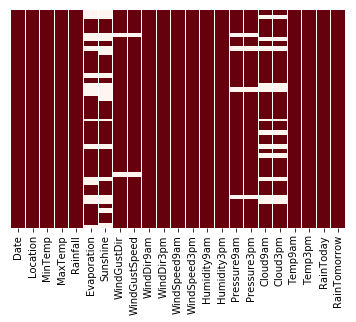

In [46]:
import seaborn
import pandas

#Assign values to response variable, y, and explanatory variables, x.
rainfall = pandas.read_csv('rainfall.csv', index_col=0) 
temp_rainfall = rainfall.copy()

# Visualising missing data:
seaborn.heatmap(temp_rainfall.isnull(),yticklabels=False,cbar=False,cmap='Reds_r')

#Variables 'Evaporation' and 'Sunshine' contained many missing values, too many to be imputed.
temp_rainfall = temp_rainfall.drop(['Evaporation', 'Sunshine'], axis = 1)

#Get name of all cities in the data frame.
l = list(temp_rainfall.Location.unique())

#Drop all observations with NaN's.  These are values that could not be imputed using the above code.
temp_rainfall.dropna(subset = list(temp_rainfall), inplace = True)

#List all cities that were dropped
for i in l:
    if i not in temp_rainfall.Location.unique():
        print(i)
        
#'Date' and 'Location' variables not needed for prediction. 
temp_rainfall = temp_rainfall.drop(['Date', 'Location'], axis = 1)

# Data Understanding 2
<b>Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertations.</b>

# Modeling and Evaluation 1
<b>Train and adjust parameters.</b>

In [44]:
if 'RainTomorrow' in temp_rainfall:
    #Response variable is 'RainTomorrow'
    y = temp_rainfall['RainTomorrow'].values
    
    #Remove response variable from dataframe
    del temp_rainfall['RainTomorrow']
    
    #Everything else is the explanatory variables used in prediction.
    x = temp_rainfall.values

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
import time

def bench_k_means(estimator, name, data):
    t0 = time.time()
    y_hat=estimator.fit_predict(data)
    print(name)
    print("Adjusted Rand Score (-1 to 1): %f" %(sklearn.metrics.adjusted_rand_score(y, y_hat)))
    print("Calinski-Harabaz Score (higher scores relates to better defined clusters): %f"
          %(sklearn.metrics.calinski_harabaz_score(X=data, labels=y_hat)))
    return y_hat
    
scl_obj = StandardScaler()
scl_obj.fit(x)
x_scaled = scl_obj.transform(x)
    
bench_k_means(KMeans(init='random', n_clusters=2), name="random", data=x)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++", data=x)
bench_k_means(KMeans(init='random', n_clusters=2), name="random, scaled", data=x_scaled)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++, scaled", data=x_scaled)


random
Adjusted Rand Score (-1 to 1): 0.002014
Calinski-Harabaz Score (higher scores relates to better defined clusters): 49773.947750
k-means++
Adjusted Rand Score (-1 to 1): 0.002012
Calinski-Harabaz Score (higher scores relates to better defined clusters): 49773.952227
random, scaled
Adjusted Rand Score (-1 to 1): -0.001029
Calinski-Harabaz Score (higher scores relates to better defined clusters): 17820.441945
k-means++, scaled
Adjusted Rand Score (-1 to 1): -0.001135
Calinski-Harabaz Score (higher scores relates to better defined clusters): 17820.438060


array([0, 1, 1, ..., 0, 0, 0])

- Unscaled data resulted in a better Adjusted Rand Score and Calinski-Harabaz Score, will use this dataset to test if DBSCAN will provide a better model.

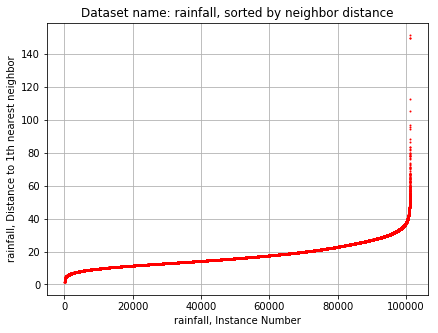

In [12]:
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import numpy

n=1 #x=1, 10, 50.  All gave the same shape, 1 was chosen because it's the least computationally expensive
X2_knn_graph = kneighbors_graph(x, n, mode='distance') # calculate distance to x nearest neighbors

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = numpy.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = numpy.sort(X2_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: rainfall, sorted by neighbor distance')
plt.xlabel('rainfall, Instance Number')
plt.ylabel('rainfall, Distance to {0}th nearest neighbor'.format(n))
plt.grid()

In [73]:
from sklearn.cluster import DBSCAN

labels=bench_k_means(DBSCAN(eps=40, min_samples=8), name="DBSCAN", data=x) #tried min_samples = 1, 100, 50, 25, 10, 5, 8

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

DBSCAN
Adjusted Rand Score (-1 to 1): 0.047572
Calinski-Harabaz Score (higher scores relates to better defined clusters): 38.101724
Estimated number of clusters: 2


# Modeling and Evaluation 2
<b>Evaluate and Compare</b>

- Scaling the observations to their means resulted in less accuracy and cluster formations, Adjusted Rand score in the negative and Calinski-Harabaz score is 17820.4 to the 49773.9 of the un-scaled dataset.
- Using a random initilization or an initialization where the centroids' distances are maximized did not seem to have much of an effect on accuracy or cluster formation.
- DBSCAN resulted in a much lower Calinski-Harabaz score, 38.1, then KMeans, 49773.0.  Indicating that DBSCAN had less defined clusters.  
- DBSCAN's Adjusted Rand Score is much larger that of KMeans, 0.05 to 0.002.  indicating there were more similarities between the predicted clusters and the true values, better accuracy.  However, perfect accuracy is 1.0, a 0.05 is not very impressive.

# Modeling and Evaluation 3
<b>Visualize Results</b>


# Modeling and Evaluation 4
<b>Summarize the Ramifications</b>


# Deployment
<b>Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?</b>

* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
* How would your deploy your model for interested parties?
* What other data should be collected?
* How often would the model need to be updated, etc.?

# Exceptional Work
<b>You have free reign to provide additional analyses or combine analyses</b>